# Dive into Abusive Language with Snorkel

Author: BingYune Chen 
<br>
Updated: 2021-08-02

----------

### Transfer Learning with BERT Classifier

The output of the Snorkel `LabelModel` is a set of labels that can be used with most popular supervised learning models such as Logistic Regression, XGBoost, and neural networks.

Google’s BERT (Bidirectional Encoder Representations from Transformers, 2018) combines context embedding (ELMO) and several Transformers, plus it’s bidirectional (which was a big novelty for Transformers). The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts. 

In order to complete a text classification task, you can use BERT in 3 different ways:
* Train it all from scratches and use it as classifier
* Extract the word embeddings and use them in an embedding layer (like I did with Word2Vec)
* Fine-tune the pre-trained model (transfer learning)

**We will focus on transfer learning to maximize the benefits of Snorkel.**

In [ ]:
# Imports and setup for Google Colab

# Mount Google Drive
from google.colab import drive ## module to use Google Drive with Python
drive.mount('/content/drive') ## mount to access contents

# Install python libraries
! pip install --upgrade tensorflow --quiet
! pip install snorkel --quiet
! pip install tensorboard==1.15.0 --quiet
! pip install transformers --quiet

In [ ]:
# Imports for data and plotting
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline 
import seaborn as sns

import pickle
import os
import re

# Imports for snorkel analysis and multi-task learning
from snorkel.labeling.model import LabelModel
from snorkel.labeling import filter_unlabeled_dataframe

# Imports for bert language model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

import transformers

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

import time
import datetime
import random

In [ ]:
# Load labeled dataset for training 
df_train = pd.read_pickle('../data/processed/df_train.pkl')
df_train.reset_index(drop=True, inplace=True)

df_valid = pd.read_pickle('../data/processed/df_valid.pkl')
df_valid.reset_index(drop=True, inplace=True)

df_test = pd.read_pickle('../data/processed/df_test.pkl')
df_test.reset_index(drop=True, inplace=True)

pd.set_option('display.max_colwidth', 500)
df_train.head()

,label,tweet
0,1,#has_mention ee you got the hoes
1,1,Most of you hoes copy and paste but there has to be someone they are copying from. And to you I give you my props
2,1,#has_mention only when ur around me 😋 got to keep dat scent to keep filthy niggers away
3,1,"#has_retweet #has_mention *hits blunt* ""bruh if she tells me to go text my other hoes, but she is one of my hoes, do I keep texting her ?"" #has_url #has_truncate"
4,1,"#has_url Alexander Skarsgard, my roommate has #has_url ""He's a sexy albino lizard. i dont know how that is sexy, but it kind of is."""


In [ ]:
# Load matrix of votes obtained from all the labeling functions
l_train = pd.read_pickle('../models/lf_train_final.pkl')
l_valid = pd.read_pickle('../models/lf_valid_final.pkl')
l_test = pd.read_pickle('../models/lf_test_final.pkl')

### Snorkel Label Model

`Majority Vote` is the simpliest function Snorkel uses to generate a class label, based on the most voted label from all of the labeling functions. However, in order to take advantage of Snorkel's full functionality, `Label Model` predicts new class labels by learning to estimate the accuracy and correlations of the labeling functions based on their conflicts and overlaps. We will use the `Label Model` function to generate a single confidence-weighted label given a matrix of predictions.

In [ ]:
# Apply LabelModel, no gold labels for training
label_model_train = LabelModel(cardinality=2, verbose=True) ## number of classes     
label_model_train.fit(L_train=l_train,
                      n_epochs=2000, 
                      log_freq=100, 
                      seed=42)

# Get our predictions for the unlabeled dataset
probs_train = label_model_train.predict(L=l_train)

In [ ]:
# Calculate Label Model accuracy using validation data
label_model_acc = label_model_train.score(
    L=l_valid, Y=df_valid.label, tie_break_policy='random'
    )['accuracy']

print(f"{'Label Model Accuracy:': <25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     84.1%


In [ ]:
# Filter out unlabeled data points
df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=l_train
    )

print('Shape of X_train: {} Shape of X_train_probs: {}'.format(
    df_train_filtered.shape, 
    probs_train_filtered.shape
    )
) # Confirm 100% coverage from labeling functions

Shape of X_train: (27960, 2) Shape of X_train_probs: (27960,)


In [ ]:
# Explore conflicts between gold labels and LM labels
df_train_filtered['lm_label'] = probs_train_filtered
df_train_filtered.loc[
    df_train_filtered['lm_label'] != df_train_filtered['label'], :].head(50)

,label,tweet,lm_label
4,1,"#has_url Alexander Skarsgard, my roommate has #has_url ""He's a sexy albino lizard. i dont know how that is sexy, but it kind of is.""",0
20,1,"#has_mention So..is the answer ""nothing""?",0
34,0,"let us talk about how #BillCosby deserves to go down asap, but where was the cascading media blitz on #WoodyAllen? Fucker is still a demigod",1
37,1,#has_mention #has_mention Given that it is WaPo..laying odds #has_truncate,0
38,1,#has_mention #has_mention your tits may be better looking but her face makes you like a Asian or Latina tranny #facts,0
46,1,"Oh dear me. Annie is a mess, also I do not see how that is a breakfast dish. #MKR",0
76,1,#has_retweet #has_mention I cannot even sit down and watch a period of women's hockey let alone a 3 hour class on it..#notsexist just not excitin #has_truncate,0
78,1,". #has_mention #has_mention ..mistake. I find both abortion & child abandonment detestable. But, if one gets an awful choice, both must",0
79,1,#has_mention #has_mention sleep niggah! Lol,0
81,1,#has_retweet #has_mention female ghostbusters ? wtfrack ? #NOTsexist,0


### Train a BERT Classifier

BERT provides a Universal Language Model, pre-trained on unlabeled data extracted from non-Twitter sources:
1.   BooksCorpus with 800M words
2.   English Wikipedia with 2,500M words

We will fine-tune the Language Model for the task at hand with a large corpus of unlabeled data points. We will then train a discriminative classifier by fine-tuning it with gradual unfreezing.

In [ ]:
# Fine tune the Language Model using Twitter Sentiment140 dataset from Kaggle
# BERT will then be able to generalize in the Twitter domain

df_twitter = pd.read_pickle('../data/processed/twitter_sentiment140.pkl')
df_twitter['target'] = df_twitter['target'].map({0: 1, 4: 0})
df_twitter.head()

,target,tweet
0,1,"#has_mention #has_url - Aww, that is a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,1,is upset that he cannot update his Facebook by texting it.. and might cry as a result School today also. Blah!
2,1,#has_mention I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,1,my whole body feels itchy and like its on fire
4,1,"#has_mention no, it is not behaving at all. i'm mad. why am i here? because I cannot see you all over there."


In [ ]:
# Split Twitter Sentiment140 dataset into train and validation
# No need for test dataset for fine-tuning

X_ts140_train, X_ts140_valid, y_ts140_train, y_ts140_valid = train_test_split(
    df_twitter['tweet'], 
    df_twitter['target'], 
    random_state=42, 
    test_size=0.3, 
    stratify=df_twitter['target']
    )

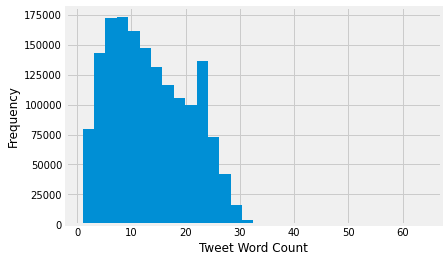

In [ ]:
# Padding will add tokens up to a max_length
# Padding tokens to not help the model learn anything useful (slower training)
seq_len = [len(i.split()) for i in df_twitter.tweet]

fig,ax = plt.subplots()

ax.hist(seq_len, bins=30, label='histogram')
ax.set_ylabel('Frequency')
ax.set_xlabel('Tweet Word Count')

plt.show(); # Most tweets have about 30 words or less

In [ ]:
# Create BERT tokenizer (original BERT of 110M parameters)
# BERT tokenizer can handle punctuation, simleys, etc.
# Previously replaced mentions and urls with special tokens (#has_url, #has_mention)

bert_token = transformers.BertTokenizerFast.from_pretrained(
    'bert-base-uncased', 
    do_lower_case=True) 

# Create helper function for text parsing

def bert_encode(tweet_df, tokenizer):
    ## add '[CLS]' token as prefix to flag start of text
    ## append '[SEP]' token to flag end of text
    ## append '[PAD]' token to fill uneven text
    bert_tokens = tokenizer.batch_encode_plus(
        tweet_df['tweet'].to_list(),
        padding='max_length', 
        truncation=True,
        max_length=30
        )
    
    ## convert list to tensors
    input_word_ids = torch.tensor(bert_tokens['input_ids'])
    input_masks = torch.tensor(bert_tokens['attention_mask'])
    input_type_ids = torch.tensor(bert_tokens['token_type_ids'])

    inputs = {
        'input_word_ids': input_word_ids,
        'input_masks': input_masks,
        'input_type_ids': input_type_ids
        }

    return inputs

In [ ]:
'''
# Save the BERT encodes for training and testing
SAVE_PATH = '../models/'
os.chdir(SAVE_PATH)

# Apply BERT encoding 
X_ts140_train_bert = bert_encode(
    pd.DataFrame(X_ts140_train, columns=['tweet']), 
    bert_token
    )

model_name1 = 'bert_tokens_ts140_xtrain.pkl'
with open(model_name1, 'wb') as file:
    pickle.dump(X_ts140_train_bert, file)

X_ts140_test_bert = bert_encode(
    pd.DataFrame(X_ts140_test, columns=['tweet']), 
    bert_token)

model_name2 = 'bert_tokens_ts140_xtest.pkl'
with open(model_name2, 'wb') as file:
    pickle.dump(X_ts140_test_bert, file)
'''

In [ ]:
'''
# Apply BERT encoding 
X_train = bert_encode(df_train, bert_token)
y_train = df_train.label.values

# Save the BERT encodes for training
model_name3 = 'bert_tokens_xtrain.pkl'
with open(model_name3, 'wb') as file:
    pickle.dump(X_train, file)

X_valid = bert_encode(df_valid, bert_token)
y_valid = df_valid.label.values

model_name4 = 'bert_tokens_xvalid.pkl'
with open(model_name4, 'wb') as file:
    pickle.dump(X_valid, file)

X_test = bert_encode(df_test, bert_token)
y_test = df_test.label.values

model_name5 = 'bert_tokens_xtest.pkl'
with open(model_name5, 'wb') as file:
    pickle.dump(X_test, file)
'''

In [ ]:
# Load BERT encodes
SAVE_PATH = '../models/'
os.chdir(SAVE_PATH)

X_ts140_train_bert = pd.read_pickle('bert_tokens_ts140_xtrain.pkl')
X_ts140_valid_bert = pd.read_pickle('bert_tokens_ts140_xvalid.pkl')

In [ ]:
# Create data loaders for train and test set
# Pass batches of train data and test data as input to the model during training

batch_size = 32 ## define batch size, authors recommend 16 or 32 for fine-tuning

# Wrap tensors for train
ts140_train_data = TensorDataset(
    X_ts140_train_bert['input_word_ids'], 
    X_ts140_train_bert['input_masks'], 
    torch.tensor(y_ts140_train.to_list())
    )

# Make sampler for sampling the data during training
ts140_train_sampler = RandomSampler(ts140_train_data)

# Make dataLoader for train set
ts140_train_dataloader = DataLoader(
    ts140_train_data, 
    sampler=ts140_train_sampler, 
    batch_size=batch_size
    )

# Wrap tensors for valid
ts140_valid_data = TensorDataset(
    X_ts140_valid_bert['input_word_ids'], 
    X_ts140_valid_bert['input_masks'], 
    torch.tensor(y_ts140_valid.to_list())
    )

# Make sampler for sampling the data during training
ts140_valid_sampler = SequentialSampler(ts140_valid_data)

# Make dataLoader for validation set
ts140_valid_dataloader = DataLoader(
    ts140_valid_data, 
    sampler=ts140_valid_sampler, 
    batch_size=batch_size
    )

In [ ]:
# Define model architecture for fine-tuning

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

nlp_bert = transformers.BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', ## use 12-layer BERT model, uncased vocab
    num_labels=2, ## binary classfication
    output_attentions = False, ## model returns attentions weights
    output_hidden_states = False, ## model returns all hidden-states
    )

nlp_bert.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

params = list(nlp_bert.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Define optimizer 
optimizer = transformers.AdamW(nlp_bert.parameters(),
                               lr=2e-5, ## learning rate
                               eps=1e-8 # small number prevent divison by zero
                               ) 

epochs = 4 ## define number of training epochs

# Check the class weights for imbalanced classes
class_weights = compute_class_weight(
    'balanced', 
    np.unique(y_ts140_train), 
    y_ts140_train
    )

print("Class Weights:", class_weights)

'''
# Update model architecture to handle imbalanced classes
weights= torch.tensor(class_weights, dtype=torch.float) ## convert to tensor
weights = weights.to(device) ## push to GPU
cross_entropy  = torch.nn.NLLLoss(weight=weights) ## define the loss function
'''

Class Weights: [1. 1.]


'\n# Update model architecture to handle imbalanced classes\nweights= torch.tensor(class_weights, dtype=torch.float) ## convert to tensor\nweights = weights.to(device) ## push to GPU\ncross_entropy  = torch.nn.NLLLoss(weight=weights) ## define the loss function\n'

In [ ]:
# Define learning rate scheduler
total_steps = len(ts140_train_dataloader) * epochs ## batches X epochs

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# Define helper functions for calculating accuracy

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

# Calculate accuracy for predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Return time in seconds as string hh:mm:ss
def format_time(elapsed):
    ## round to the nearest second
    elapsed_rounded = int(round((elapsed)))
    ## format as hh:mm:ssa
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Run training loop

# Code adapted from Chris McCormick
# >>> https://mccormickml.com/2019/07/22/BERT-fine-tuning/#32-required-formatting

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# Loop each epoch...
for epoch_i in range(0, epochs):
    ## perform one full pass over the training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    ## measure how long the training epoch takes.
    t0 = time.time()

    ## reset the total loss for this epoch.
    total_train_loss = 0

    ## put the model into training mode     
    nlp_bert.train()

    ## loop each batch of training data...
    for step, batch in enumerate(ts140_train_dataloader):

        ## update progress every 40 batches
        if step % 40 == 0 and not step == 0:
            ## calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            ## report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                step, len(ts140_train_dataloader), elapsed))

        ## unpack this training batch from our dataloader
        ## NOTE: `model.to(device) is in-place operation
        ## batch (Tensor) to GPU is not in-place operation
        b_input_ids = batch[0].to('cuda') ## input ids
        b_input_mask = batch[1].to('cuda') ## attention masks
        b_labels = batch[2].to('cuda') ## labels

        ## Clear previously calculated gradients before performing backward pass         
        nlp_bert.zero_grad()        

        ## perform a forward pass (evaluate the model on this training batch)
        loss_logit_dict = nlp_bert(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels
                                   )
        loss =  loss_logit_dict['loss']
        logits = loss_logit_dict['logits']

        ## accumulate the training loss over all of the batches
        ## calculate the average loss at the end 
        total_train_loss += loss.item()

        ## perform a backward pass to calculate the gradients
        loss.backward()

        ## clip the norm of the gradients to 1.0
        ## prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(nlp_bert.parameters(), 1.0)

        ## update parameters and take a step using the computed gradient
        optimizer.step() ## dictates update rule based on gradients, lr, etc.

        ## update the learning rate
        scheduler.step()

    ## calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(ts140_train_dataloader)            
    
    ## measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    ## start validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    ## put the model in evaluation mode--the dropout layers behave differently
    nlp_bert.eval()

    ## define tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    ## evaluate data for one epoch
    for batch in ts140_valid_dataloader:
        
        ## unpack this training batch from our dataloader
        b_input_ids = batch[0].to('cuda') ## input ids
        b_input_mask = batch[1].to('cuda') ## attention masks
        b_labels = batch[2].to('cuda') ## labels
        
        ## tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            ## check forward pass, calculate logit predictions
            loss_logit_dict = nlp_bert(b_input_ids,
                                    token_type_ids=None,
                                    ## segment ids for multiple sentences
                                    attention_mask=b_input_mask,
                                    labels=b_labels
                                    )
            loss =  loss_logit_dict['loss']
            logits = loss_logit_dict['logits']

        ## accumulate the validation loss
        total_eval_loss += loss.item()

        ## move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        ## calculate the accuracy for this batch of tweets
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    ## report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(ts140_valid_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    ## calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(ts140_valid_dataloader)
    
    ## measure how long the validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    ## record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(
    format_time(time.time()-total_t0)
    )
)



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  35,000.    Elapsed: 0:00:05.
  Batch    80  of  35,000.    Elapsed: 0:00:10.
  Batch   120  of  35,000.    Elapsed: 0:00:15.
  Batch   160  of  35,000.    Elapsed: 0:00:20.
  Batch   200  of  35,000.    Elapsed: 0:00:24.
  Batch   240  of  35,000.    Elapsed: 0:00:29.
  Batch   280  of  35,000.    Elapsed: 0:00:34.
  Batch   320  of  35,000.    Elapsed: 0:00:39.
  Batch   360  of  35,000.    Elapsed: 0:00:44.
  Batch   400  of  35,000.    Elapsed: 0:00:49.
  Batch   440  of  35,000.    Elapsed: 0:00:53.
  Batch   480  of  35,000.    Elapsed: 0:00:58.
  Batch   520  of  35,000.    Elapsed: 0:01:03.
  Batch   560  of  35,000.    Elapsed: 0:01:08.
  Batch   600  of  35,000.    Elapsed: 0:01:13.
  Batch   640  of  35,000.    Elapsed: 0:01:18.
  Batch   680  of  35,000.    Elapsed: 0:01:22.
  Batch   720  of  35,000.    Elapsed: 0:01:27.
  Batch   760  of  35,000.    Elapsed: 0:01:32.
  Batch   800  of  35,000.    Elapsed: 0:01:3

In [ ]:
'''
# Save the default names for the model
SAVE_PATH = '../models/'

# Save current state with best parameters
torch.save(nlp_bert.state_dict(), 
           os.path.join(SAVE_PATH, 'model_bert_ts140_statedict.pt')
           )

# Save full model
torch.save(nlp_bert, '../models/model_bert_ts140_full_vf.pt')

# Save checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': nlp_bert.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, '../models/model_bert_ts140_checkpoint_vf.pt')
'''